In [1]:
pip install torch torchvision pywt matplotlib opencv-python numpy

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt

[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install PyWavelets

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB 640.0 kB/s eta 0:00:07
   -- ------------------------------------- 0.3/4.2 MB 3.2 MB/s eta 0:00:02
   -------------- ------------------------- 1.5/4.2 MB 12.0 MB/s eta 0:00:01
   ---------------------------- ----------- 3.0/4.2 MB 17.2 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.2 MB 20.7 MB/s eta 0:00:01
   ---------------------------------------- 4.2/4.2 MB 19.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Epoch [1/10] - Loss: 0.0126
Epoch [2/10] - Loss: 0.0050
Epoch [3/10] - Loss: 0.0048
Epoch [4/10] - Loss: 0.0042
Epoch [5/10] - Loss: 0.0039
Epoch [6/10] - Loss: 0.0038
Epoch [7/10] - Loss: 0.0037
Epoch [8/10] - Loss: 0.0037
Epoch [9/10] - Loss: 0.0033
Epoch [10/10] - Loss: 0.0034
Models saved.


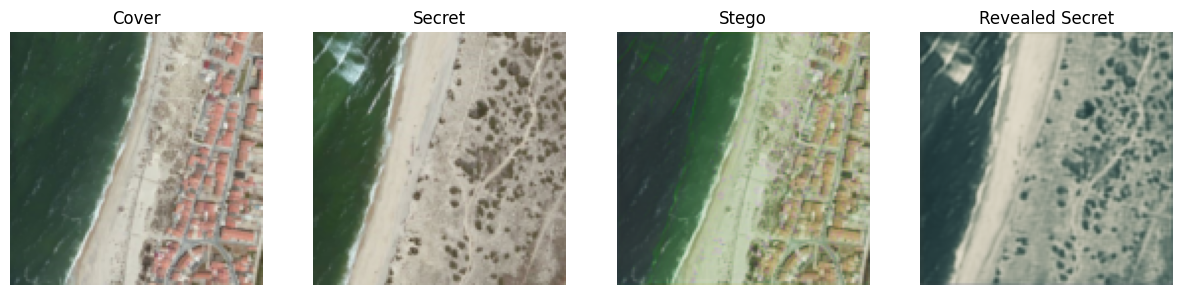

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pywt
import numpy as np
import matplotlib.pyplot as plt

# ---------- Wavelet Helper ----------
def dwt2(image):
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs
    return np.stack((cA, cH, cV, cD), axis=0)

def idwt2(coeffs):
    cA, cH, cV, cD = coeffs[0], coeffs[1], coeffs[2], coeffs[3]
    return pywt.idwt2((cA, (cH, cV, cD)), 'haar')

def to_wavelet(img_tensor):
    img_np = img_tensor.squeeze().permute(1, 2, 0).numpy()
    coeffs = [dwt2(img_np[:, :, i]) for i in range(3)]
    return torch.tensor(np.stack(coeffs)).float()

def from_wavelet(coeff_tensor):
    coeff_np = coeff_tensor.numpy()
    reconstructed = [idwt2(coeff_np[i]) for i in range(3)]
    result = np.stack(reconstructed, axis=2)
    return torch.tensor(result).permute(2, 0, 1)

# ---------- Dataset ----------
class StegoImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        cover = Image.open(self.image_paths[idx]).convert("RGB")
        secret = Image.open(random.choice(self.image_paths)).convert("RGB")
        if self.transform:
            cover = self.transform(cover)
            secret = self.transform(secret)
        return cover, secret

# ---------- Encoder ----------
class WNNEncoder(nn.Module):
    def __init__(self):
        super(WNNEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), nn.Sigmoid()  # Output stego image (3 channels)
        )

    def forward(self, cover, secret):
        x = torch.cat([cover, secret], dim=1)
        return self.net(x)  # stego image
        
# ---------- Decoder ----------
class WNNDecoder(nn.Module):
    def __init__(self):
        super(WNNDecoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), nn.Sigmoid()  # Output recovered secret
        )

    def forward(self, stego):
        return self.net(stego)

# ---------- Training ----------
def train(encoder, decoder, dataloader, device, epochs=10):
    encoder.train()
    decoder.train()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for cover, secret in dataloader:
            cover, secret = cover.to(device), secret.to(device)
            stego = encoder(cover, secret)
            revealed = decoder(stego)
            loss = criterion(stego, cover) + criterion(revealed, secret)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss / len(dataloader):.4f}")

    torch.save(encoder.state_dict(), "wnn_encoder.pth")
    torch.save(decoder.state_dict(), "wnn_decoder.pth")
    print("Models saved.")

# ---------- Test ----------
def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, title in zip(axs, images, titles):
        ax.imshow(img.cpu().permute(1, 2, 0).detach().numpy())
        ax.set_title(title)
        ax.axis('off')
    plt.show()

def test(encoder, decoder, transform, device):
    cover = Image.open(r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_1.png" ).convert("RGB")
    secret = Image.open(r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_2.png").convert("RGB")
    cover = transform(cover).unsqueeze(0).to(device)
    secret = transform(secret).unsqueeze(0).to(device)

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        stego = encoder(cover, secret)
        revealed = decoder(stego)

    show_images([cover[0], secret[0], stego[0], revealed[0]],
            ["Cover", "Secret", "Stego", "Revealed Secret"])

# ---------- Main ----------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    # Training
    dataset = StegoImageDataset("images", transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    encoder = WNNEncoder().to(device)
    decoder = WNNDecoder().to(device)

    train(encoder, decoder, dataloader, device, epochs=10)

    # Testing
    encoder.load_state_dict(torch.load("wnn_encoder.pth"))
    decoder.load_state_dict(torch.load("wnn_decoder.pth"))
    test(encoder, decoder, transform, device)

# EVALUATION


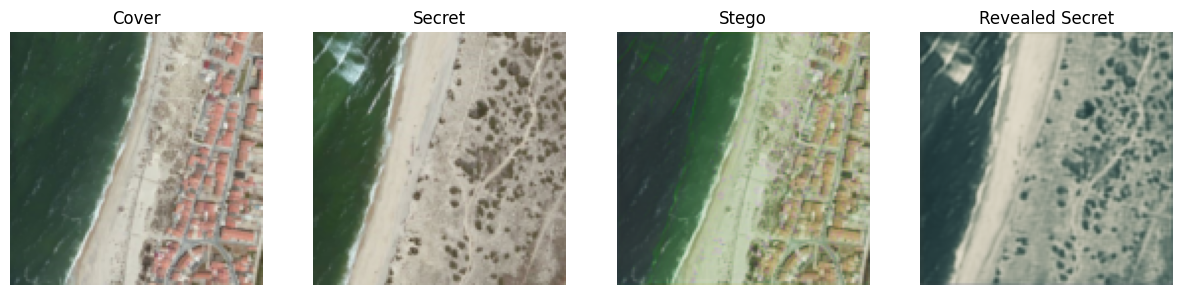

PSNR: 27.7748
SSIM: 0.9360
Cover Entropy: 7.3549
Stego Entropy: 7.2548
Revealed Entropy: 7.3973
BER (Cover vs Revealed): 0.3434


In [7]:
import numpy as np
import torch
import torch.nn.functional as F
import math
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import matplotlib.pyplot as plt

# --------------------- PSNR ---------------------
def psnr(img1, img2):
    mse = F.mse_loss(img1, img2).item()
    if mse == 0:
        return 100
    max_pixel = 1.0  # since the images are normalized to [0, 1]
    return 20 * math.log10(max_pixel / math.sqrt(mse))

# --------------------- SSIM ---------------------
def ssim_metric(img1, img2):
    img1 = img1.squeeze().permute(1, 2, 0).cpu().numpy()
    img2 = img2.squeeze().permute(1, 2, 0).cpu().numpy()
    return ssim(img1, img2, win_size=7, channel_axis=2, data_range=1.0)


# --------------------- Entropy ---------------------
def entropy(img):
    img = img.squeeze().permute(1, 2, 0).cpu().numpy()
    histogram, _ = np.histogram(img, bins=256, range=(0, 1))
    prob = histogram / np.sum(histogram)
    prob = prob[prob > 0]
    return -np.sum(prob * np.log2(prob))


# --------------------- Bit Error Rate (BER) ---------------------
def ber(img1, img2):
    # Flatten the images to 1D
    img1_flat = (img1 > 0.5).int().cpu().numpy().flatten()  # Threshold at 0.5 to get binary values
    img2_flat = (img2 > 0.5).int().cpu().numpy().flatten()
    return np.sum(img1_flat != img2_flat) / len(img1_flat)

# --------------------- Test Evaluation ---------------------
def evaluate_metrics(cover, stego, revealed):
    # PSNR
    psnr_value = psnr(cover, stego)
    
    # SSIM
    ssim_value = ssim_metric(cover, stego)
    
    # Entropy
    cover_entropy = entropy(cover)
    stego_entropy = entropy(stego)
    revealed_entropy = entropy(revealed)
    
    # BER (Bit Error Rate)
    ber_value = ber(cover, revealed)

    # Print metrics
    print(f"PSNR: {psnr_value:.4f}")
    print(f"SSIM: {ssim_value:.4f}")
    print(f"Cover Entropy: {cover_entropy:.4f}")
    print(f"Stego Entropy: {stego_entropy:.4f}")
    print(f"Revealed Entropy: {revealed_entropy:.4f}")
    print(f"BER (Cover vs Revealed): {ber_value:.4f}")

# --------------------- Main ---------------------
def test_and_evaluate(encoder, decoder, transform, device, cover_path, secret_path):
    # Load and process images
    cover = Image.open(cover_path).convert("RGB")
    secret = Image.open(secret_path).convert("RGB")
    cover = transform(cover).unsqueeze(0).to(device)
    secret = transform(secret).unsqueeze(0).to(device)

    # Set models to evaluation mode
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        stego = encoder(cover, secret)
        revealed = decoder(stego)

    # Show images
    show_images([cover[0], secret[0], stego[0], revealed[0]],
                ["Cover", "Secret", "Stego", "Revealed Secret"])

    # Evaluate metrics
    evaluate_metrics(cover, stego, revealed)

# --------------------- Main Script ---------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    # Paths to the images
    cover_image_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_1.png"
    secret_image_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_2.png"

    # Initialize models (these should be trained and saved as encoder.pth and decoder.pth)
    encoder = WNNEncoder().to(device)
    decoder = WNNDecoder().to(device)

    encoder.load_state_dict(torch.load("wnn_encoder.pth"))
    decoder.load_state_dict(torch.load("wnn_decoder.pth"))

    # Test and evaluate
    test_and_evaluate(encoder, decoder, transform, device, cover_image_path, secret_image_path)

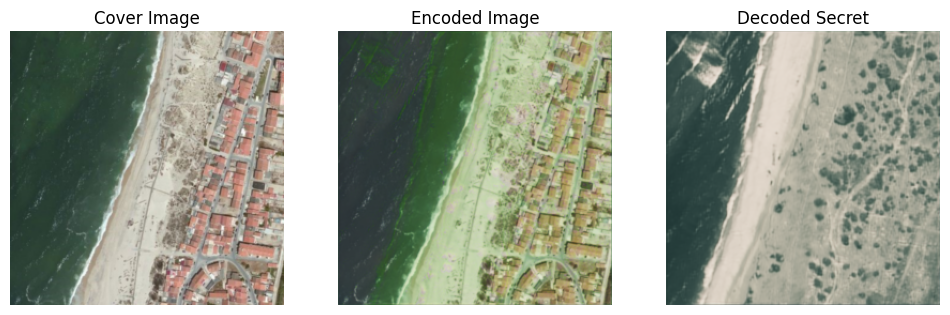

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# ---------------- Encoder ---------------- #

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, 3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, cover, secret):
        x = torch.cat([cover, secret], dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))
        return x


# ---------------- Decoder ---------------- #

# Adjust Decoder architecture to match the saved model
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 32 filters
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 64 filters
        self.conv3 = nn.Conv2d(64, 3, 3, padding=1)  # 3 filters (for RGB)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, encoded_image):
        x = self.relu(self.conv1(encoded_image))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))
        return x



# ---------------- Image Loader ---------------- #

def load_image(path, transform):
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0)


# ---------------- Main Test ---------------- #

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# Load models
encoder.load_state_dict(torch.load("encoder.pth", map_location=device))
decoder.load_state_dict(torch.load("decoder.pth", map_location=device))

encoder.eval()
decoder.eval()

# Example transform and image paths
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

cover_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_1.png"
secret_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_2.png"

cover_image = load_image(cover_path, transform).to(device)
secret_image = load_image(secret_path, transform).to(device)

# Encode
with torch.no_grad():
    encoded_image = encoder(cover_image, secret_image)
    decoded_secret = decoder(encoded_image)

# Convert tensors to numpy images for display
def tensor_to_image(tensor):
    image = tensor.cpu().squeeze().permute(1, 2, 0).numpy()
    image = np.clip(image, 0, 1)
    return image

encoded_image_np = tensor_to_image(encoded_image)
decoded_secret_np = tensor_to_image(decoded_secret)

# Display images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Cover Image")
plt.imshow(tensor_to_image(cover_image))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Encoded Image")
plt.imshow(encoded_image_np)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Decoded Secret")
plt.imshow(decoded_secret_np)
plt.axis("off")

plt.show()


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)

encoder.load_state_dict(torch.load("wnn_encoder.pth", map_location=device), strict=False)
decoder.load_state_dict(torch.load("wnn_decoder.pth", map_location=device), strict=False)


encoder.eval()
decoder.eval()

Decoder(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [13]:
import torch
import torch.nn as nn

# Assuming the Encoder and Decoder classes are defined elsewhere and imported.

# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the encoder and decoder models and move them to the available device (GPU/CPU)
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# Load the pre-trained weights for encoder and decoder from specified .pth files
encoder.load_state_dict(torch.load("wnn_encoder.pth", map_location=device), strict=False)
decoder.load_state_dict(torch.load("wnn_decoder.pth", map_location=device), strict=False)

# Set both models to evaluation mode to disable dropout, batch norm, etc.
encoder.eval()
decoder.eval()

print("Models loaded and set to evaluation mode.")


Models loaded and set to evaluation mode.


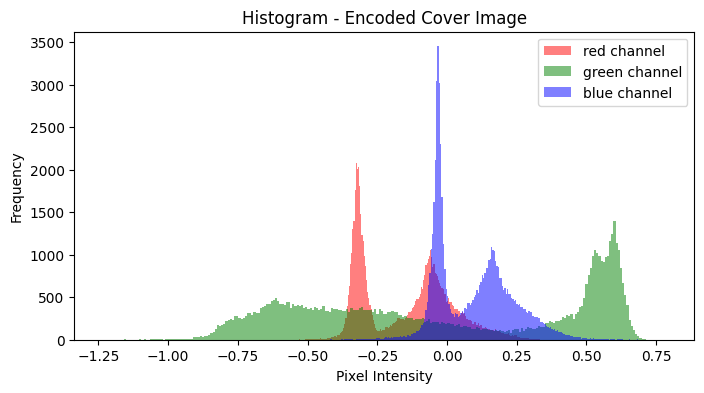

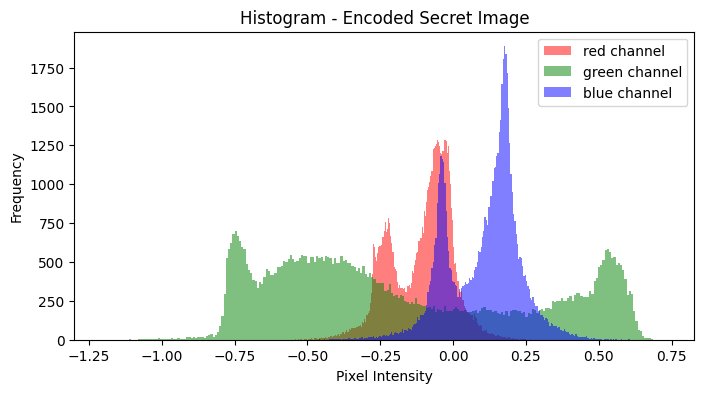

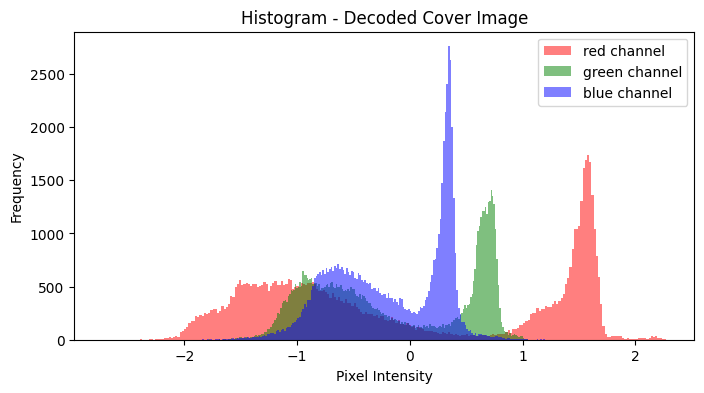

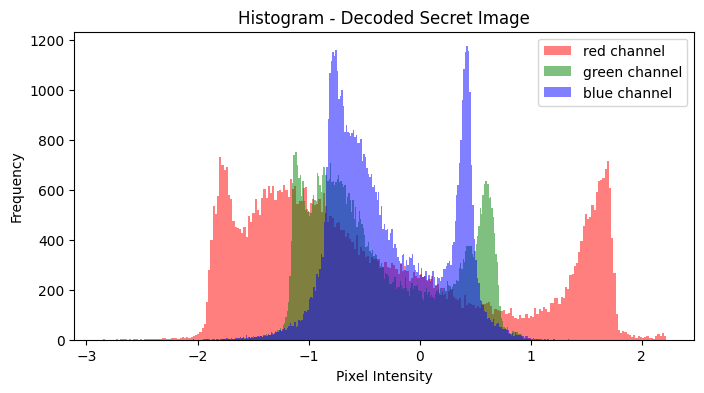

In [15]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# Define the encoder and decoder (assuming you've already implemented them)
# For now, I'm using placeholders for the models as examples
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Example encoder layers (change based on your actual model)
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Example decoder layers (change based on your actual model)
        self.deconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv2 = torch.nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        return x

# Load your encoder and decoder models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# Load the pre-trained models (make sure the model files are correct)
encoder.load_state_dict(torch.load("wnn_encoder.pth", map_location=device), strict=False)
decoder.load_state_dict(torch.load("wnn_decoder.pth", map_location=device), strict=False)

encoder.eval()
decoder.eval()

# Define a function to plot the histogram
def plot_histogram(tensor, title):
    image = tensor.cpu().squeeze(0).detach().numpy()  # shape: [C, H, W]
    colors = ['red', 'green', 'blue']
    plt.figure(figsize=(8, 4))

    for i in range(3):
        plt.hist(image[i].flatten(), bins=256, color=colors[i], alpha=0.5, label=f'{colors[i]} channel')

    plt.title(f'Histogram - {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Paths to your images
cover_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_1.png"
secret_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_2.png"

# Load the images and apply transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a consistent size (e.g., 256x256)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load and transform the images
cover_image = Image.open(cover_path).convert('RGB')
secret_image = Image.open(secret_path).convert('RGB')

cover_tensor = transform(cover_image).unsqueeze(0).to(device)  # Add batch dimension and move to device
secret_tensor = transform(secret_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Encode the images
encoded_cover = encoder(cover_tensor)
encoded_secret = encoder(secret_tensor)

# Decode the images
decoded_cover = decoder(encoded_cover)
decoded_secret = decoder(encoded_secret)

# Plot histograms
plot_histogram(encoded_cover, title="Encoded Cover Image")
plot_histogram(encoded_secret, title="Encoded Secret Image")
plot_histogram(decoded_cover, title="Decoded Cover Image")
plot_histogram(decoded_secret, title="Decoded Secret Image")


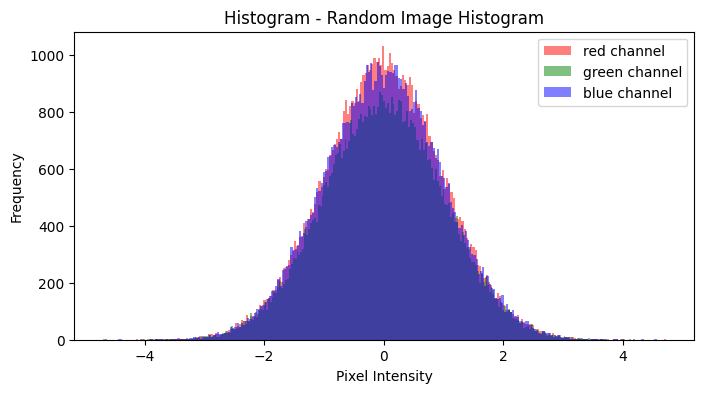

In [12]:
import torch

# Example: Generate a random image tensor of shape [1, 3, 256, 256] (1 batch, 3 channels, 256x256 image)
image_tensor = torch.randn(1, 3, 256, 256)

# Call the function with the generated tensor and a title
plot_histogram(image_tensor, "Random Image Histogram")
